In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_05/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.22585% 	8.95055% 	0.04888		0.046		0.0		1.0	
(1024,256) 	95.4% 		0.47131% 	6.45729% 	0.82382		0.80618		0.0		0.96703	
(1024,1024) 	3.04% 		1.88206% 	2.31938% 	0.02452		0.00355		0.0		0.43489	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.99999 1.00000 0.00001 	(213910, 0.9037879560274013) 0.87663 0.90379 0.02716 	(688427, 0.938751472320377) 0.01573 0.93875 0.92302 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.88852 0.89420 0.00567 	(4240, 0.9623085983510011) 0.28774 0.96231 0.67456 	
(2436, 1.0) 0.98405 1.00000 0.01595 	(44828, 0.8401417658060423) 0.85180 0.84014 0.01166 	(694929, 0.9799764428739693) 0.00341 0.97998 0.97657 	
(55808, 1.0) 0.99979 1.00000 0.00021 	(232148, 0.8783613613364569) 0.86533 0.87836 0.01303 	(600540, 0.5747938751472321) 0.04419 0.57479 0.53061 	
(44159, 1.0) 0.99954 1.00000 0.00046 	(106790, 0.8420843224691953) 0.83839 0.84208 0.00369 	(226406, 0.8680800942285042) 0.08656 0.86808 0.78152 	
(25344, 1.0) 0.99999 1.00000 0.00001 	(155900, 0.8219974944514251) 0.81976 0.82200 0.00223 	(122896, 0.99528857

(17152, 1.0) 1.00000 1.00000 0.00000 	(71512, 0.9671947492957347) 0.85141 0.96719 0.11578 	(571684, 0.8881036513545347) 0.03107 0.88810 0.85703 	
(5505, 1.0) 0.36444 1.00000 0.63556 	(136388, 0.8390310859768031) 0.85324 0.83903 0.01421 	(700469, 0.9057714958775029) 0.08261 0.90577 0.82316 	
(1727, 1.0) 0.12268 1.00000 0.87732 	(141587, 0.9235756318547628) 0.86531 0.92358 0.05827 	(208581, 0.08362779740871625) 0.00101 0.08363 0.08262 	
(30605, 1.0) 1.00000 1.00000 0.00000 	(26153, 0.7452398860506029) 0.75680 0.74524 0.01156 	(157174, 1.0) 0.13127 1.00000 0.86873 	
(76288, 1.0) 1.00000 1.00000 0.00000 	(36157, 0.8362968225795768) 0.77575 0.83630 0.06054 	(20954, 0.9187279151943463) 0.07620 0.91873 0.84253 	
(26018, 1.0) 0.99898 1.00000 0.00102 	(28890, 0.8669332866269653) 0.82770 0.86693 0.03924 	(181702, 0.6819787985865724) 0.03838 0.68198 0.64359 	
(15488, 1.0) 1.00000 1.00000 0.00000 	(66509, 0.913707448314581) 0.84773 0.91371 0.06597 	(456980, 0.9316843345111897) 0.11083 0.93168 0.82

(101632, 1.0) 1.00000 1.00000 0.00000 	(109056, 0.8128818385580182) 0.82676 0.81288 0.01388 	(37897, 0.6395759717314488) 0.31444 0.63958 0.32514 	
(2813, 1.0) 0.77101 1.00000 0.22899 	(106336, 0.837155641146507) 0.82321 0.83716 0.01395 	(70064, 1.0) 0.12239 1.00000 0.87761 	
(57494, 1.0) 0.99912 1.00000 0.00088 	(127674, 0.8341266731748087) 0.84533 0.83413 0.01120 	(219145, 0.43934040047114253) 0.31444 0.43934 0.12490 	
(52733, 1.0) 1.00000 1.00000 0.00000 	(215375, 0.915671669561574) 0.86127 0.91567 0.05440 	(550003, 0.8881036513545347) 0.02427 0.88810 0.86383 	
(13193, 1.0) 0.99876 1.00000 0.00124 	(220183, 0.9147932322091735) 0.88731 0.91479 0.02749 	(14454, 0.9681978798586572) 0.27180 0.96820 0.69640 	
(60969, 1.0) 0.99989 1.00000 0.00011 	(238049, 0.8699697832692983) 0.86562 0.86997 0.00435 	(137272, 0.7915194346289753) 0.18743 0.79152 0.60409 	
(36741, 1.0) 0.97606 1.00000 0.02394 	(110609, 0.8160256395173594) 0.83896 0.81603 0.02293 	(386160, 0.9305064782096585) 0.08319 0.93051 

(8704, 1.0) 1.00000 1.00000 0.00000 	(259153, 0.8037750467161057) 0.80451 0.80378 0.00073 	(299346, 0.7997644287396938) 0.03588 0.79976 0.76388 	
(23134, 1.0) 0.99946 1.00000 0.00054 	(100918, 0.8146914596893262) 0.84328 0.81469 0.02859 	(108806, 0.9269729093050648) 0.16692 0.92697 0.76005 	
(51583, 1.0) 1.00000 1.00000 0.00000 	(147885, 0.918594242616171) 0.88546 0.91859 0.03314 	(127210, 0.04711425206124857) 0.08671 0.04711 0.03960 	
(71300, 1.0) 0.98764 1.00000 0.01236 	(161769, 0.8889750997549195) 0.85137 0.88898 0.03761 	(479439, 0.9316843345111897) 0.04515 0.93168 0.88653 	
(67713, 1.0) 0.97331 1.00000 0.02669 	(114369, 0.948370456114582) 0.92701 0.94837 0.02136 	(175119, 0.9976442873969376) 0.27876 0.99764 0.71889 	
(23831, 1.0) 1.00000 1.00000 0.00000 	(256541, 0.8888296102974736) 0.87073 0.88883 0.01810 	(203825, 0.9116607773851589) 0.18743 0.91166 0.72423 	
(9752, 1.0) 1.00000 1.00000 0.00000 	(17541, 0.7695029790757576) 0.76678 0.76950 0.00272 	(26981, 0.8362779740871614) 0.

(9478, 1.0) 1.00000 1.00000 0.00000 	(241773, 0.882401444198903) 0.86699 0.88240 0.01542 	(293095, 0.9375736160188458) 0.07027 0.93757 0.86730 	
(45446, 1.0) 0.99904 1.00000 0.00096 	(67783, 0.8759594696412678) 0.87804 0.87596 0.00208 	(18458, 0.4534746760895171) 0.35858 0.45347 0.09489 	
(44605, 1.0) 0.99988 1.00000 0.00012 	(210907, 0.8546827162023052) 0.87008 0.85468 0.01540 	(212090, 0.9976442873969376) 0.25281 0.99764 0.74484 	
(644, 1.0) 0.43452 1.00000 0.56548 	(71641, 0.949059453998139) 0.86829 0.94906 0.08077 	(167098, 0.684334511189635) 0.07994 0.68433 0.60439 	
(6179, 1.0) 0.52592 1.00000 0.47408 	(213647, 0.8911479654055573) 0.87248 0.89115 0.01866 	(1049, 0.9575971731448765) 0.21126 0.95760 0.74633 	
(23120, 1.0) 0.94531 1.00000 0.05469 	(223455, 0.897868826237847) 0.86289 0.89787 0.03498 	(824565, 0.7938751472320377) 0.01116 0.79388 0.78271 	
(57031, 1.0) 0.99136 1.00000 0.00864 	(256244, 0.8877472124874322) 0.87421 0.88775 0.01353 	(42291, 0.8916372202591284) 0.07868 0.8

(91397, 1.0) 1.00000 1.00000 0.00000 	(140329, 0.9288307329111433) 0.85725 0.92883 0.07158 	(734568, 0.8904593639575972) 0.02374 0.89046 0.86672 	
(47491, 1.0) 1.00000 1.00000 0.00000 	(255507, 0.8895527033759333) 0.87910 0.88955 0.01046 	(450326, 0.9375736160188458) 0.01175 0.93757 0.92582 	
(23817, 1.0) 0.99931 1.00000 0.00069 	(248701, 0.9042644236060254) 0.86959 0.90426 0.03467 	(243864, 0.34275618374558303) 0.05714 0.34276 0.28562 	
(23434, 1.0) 0.94252 1.00000 0.05748 	(117161, 0.8381221871325827) 0.85388 0.83812 0.01576 	(310390, 0.49469964664310956) 0.09860 0.49470 0.39610 	
(82820, 1.0) 1.00000 1.00000 0.00000 	(49206, 0.7949334068627762) 0.76806 0.79493 0.02687 	(246223, 0.9528857479387515) 0.06891 0.95289 0.88398 	
(49792, 1.0) 0.99952 1.00000 0.00048 	(224404, 0.8928921982333976) 0.87124 0.89289 0.02165 	(4246, 0.4334511189634865) 0.26468 0.43345 0.16877 	
(8980, 1.0) 0.97979 1.00000 0.02021 	(190381, 0.9029095648609934) 0.86724 0.90291 0.03567 	(206081, 0.3745583038869259)

(9852, 1.0) 0.99995 1.00000 0.00005 	(244442, 0.8773632836088642) 0.86274 0.87736 0.01462 	(585926, 0.9163722025912839) 0.03871 0.91637 0.87766 	
(55680, 1.0) 0.99977 1.00000 0.00023 	(157713, 0.8782103694437675) 0.84438 0.87821 0.03383 	(91189, 0.938751472320377) 0.18743 0.93875 0.75132 	
(31101, 1.0) 1.00000 1.00000 0.00000 	(244670, 0.8743998106929595) 0.86632 0.87440 0.00808 	(266377, 0.3250883392226148) 0.17779 0.32509 0.14730 	
(86530, 1.0) 1.00000 1.00000 0.00000 	(14588, 0.7732518079759424) 0.66864 0.77325 0.10461 	(531014, 0.6678445229681979) 0.02862 0.66784 0.63923 	
(51964, 1.0) 1.00000 1.00000 0.00000 	(52676, 0.8789885737958777) 0.87044 0.87899 0.00855 	(461859, 1.0) 0.12503 1.00000 0.87497 	
(4390, 1.0) 0.23216 1.00000 0.76784 	(127125, 0.8358503411308392) 0.84676 0.83585 0.01091 	(392444, 0.7962308598351) 0.06717 0.79623 0.72906 	
(53631, 1.0) 1.00000 1.00000 0.00000 	(215653, 0.9154732049195081) 0.87759 0.91547 0.03789 	(438752, 0.9658421672555949) 0.03875 0.96584 0.927

(30469, 1.0) 1.00000 1.00000 0.00000 	(258347, 0.7675942870577638) 0.78243 0.76759 0.01484 	(82475, 0.9458186101295644) 0.31833 0.94582 0.62748 	
(102018, 1.0) 1.00000 1.00000 0.00000 	(164181, 0.8436562276250357) 0.84058 0.84366 0.00308 	(337939, 0.8869257950530036) 0.09889 0.88693 0.78803 	
(41856, 1.0) 1.00000 1.00000 0.00000 	(83366, 0.8287375376192538) 0.86666 0.82874 0.03792 	(112835, 0.9481743227326267) 0.11477 0.94817 0.83340 	
(87172, 1.0) 1.00000 1.00000 0.00000 	(110766, 0.8223818998939938) 0.86246 0.82238 0.04007 	(104570, 0.9316843345111897) 0.16200 0.93168 0.76968 	
(38659, 1.0) 0.94424 1.00000 0.05576 	(10796, 0.7511975364267863) 0.31279 0.75120 0.43841 	(64582, 0.8445229681978799) 0.16754 0.84452 0.67699 	
(22931, 1.0) 1.00000 1.00000 0.00000 	(199589, 0.8570338589583322) 0.83538 0.85703 0.02166 	(141339, 0.8904593639575972) 0.22631 0.89046 0.66415 	
(40728, 1.0) 0.99195 1.00000 0.00805 	(58967, 0.8948085077716741) 0.82965 0.89481 0.06516 	(331249, 0.9976442873969376) 0

(76419, 1.0) 1.00000 1.00000 0.00000 	(262097, 0.8554801779160757) 0.77362 0.85548 0.08186 	(594115, 0.7267373380447586) 0.04341 0.72674 0.68333 	
(36995, 1.0) 0.98590 1.00000 0.01410 	(34992, 0.8202230969471466) 0.77912 0.82022 0.04110 	(358497, 0.7597173144876326) 0.07348 0.75972 0.68624 	
(10419, 1.0) 0.96724 1.00000 0.03276 	(223373, 0.9005183883602514) 0.87064 0.90052 0.02988 	(118983, 0.8881036513545347) 0.08208 0.88810 0.80603 	
(49532, 1.0) 1.00000 1.00000 0.00000 	(140182, 0.8393154904920529) 0.85184 0.83932 0.01253 	(189879, 0.7314487632508835) 0.09763 0.73145 0.63382 	
(68739, 1.0) 1.00000 1.00000 0.00000 	(70384, 0.8531100423492085) 0.85490 0.85311 0.00179 	(175122, 0.9976442873969376) 0.26510 0.99764 0.73255 	
(5922, 1.0) 0.39686 1.00000 0.60314 	(125236, 0.8379360155226823) 0.85651 0.83794 0.01857 	(68674, 0.7797408716136632) 0.18301 0.77974 0.59673 	
(7688, 1.0) 1.00000 1.00000 0.00000 	(54244, 0.9653793642545262) 0.85479 0.96538 0.11059 	(505033, 0.9517078916372204) 0.1

(11162, 1.0) 0.97971 1.00000 0.02029 	(232794, 0.8671907636954468) 0.86446 0.86719 0.00273 	(130341, 0.9787985865724382) 0.05240 0.97880 0.92640 	
(73130, 1.0) 0.99997 1.00000 0.00003 	(24246, 0.7428232016736454) 0.75107 0.74282 0.00824 	(65701, 0.7879858657243817) 0.10235 0.78799 0.68563 	
(57118, 1.0) 0.99442 1.00000 0.00558 	(88928, 0.8895980111021835) 0.87051 0.88960 0.01909 	(244737, 0.9434628975265018) 0.23835 0.94346 0.70511 	
(40325, 1.0) 0.99991 1.00000 0.00009 	(193435, 0.9080030121591641) 0.86404 0.90800 0.04396 	(105733, 0.45936395759717313) 0.15546 0.45936 0.30390 	
(106112, 1.0) 1.00000 1.00000 0.00000 	(140564, 0.8477787045047577) 0.86564 0.84778 0.01786 	(705890, 0.9199057714958776) 0.01215 0.91991 0.90775 	
(18584, 1.0) 0.99849 1.00000 0.00151 	(64508, 0.8588877954908085) 0.85149 0.85889 0.00740 	(1047731, 0.06478209658421678) 0.08423 0.06478 0.01945 	
(120321, 1.0) 1.00000 1.00000 0.00000 	(231512, 0.8756322643430362) 0.86329 0.87563 0.01234 	(43416, 0.744405182567726

(23679, 1.0) 1.00000 1.00000 0.00000 	(100887, 0.7940604868505404) 0.82459 0.79406 0.03053 	(181680, 1.0) 0.07498 1.00000 0.92502 	
(74764, 1.0) 0.99999 1.00000 0.00001 	(81532, 0.9484657689158202) 0.89560 0.94847 0.05287 	(571764, 0.8833922261484101) 0.03087 0.88339 0.85252 	
(33427, 1.0) 0.99999 1.00000 0.00001 	(146175, 0.9194595428398035) 0.82865 0.91946 0.09081 	(354403, 0.4711425206124853) 0.05892 0.47114 0.41222 	
(101376, 1.0) 1.00000 1.00000 0.00000 	(172140, 0.8954859803061305) 0.85966 0.89549 0.03582 	(163185, 0.9787985865724382) 0.06131 0.97880 0.91749 	
(71424, 1.0) 0.99928 1.00000 0.00072 	(115933, 0.9281417952022871) 0.89306 0.92814 0.03508 	(317776, 0.003533568904593741) 0.04899 0.00353 0.04545 	
(11035, 1.0) 0.95921 1.00000 0.04079 	(82485, 0.9123629163657702) 0.82814 0.91236 0.08422 	(166153, 0.9599528857479388) 0.06846 0.95995 0.89149 	
(23936, 1.0) 1.00000 1.00000 0.00000 	(40504, 0.7919990039937993) 0.79794 0.79200 0.00594 	(44455, 0.9210836277974088) 0.07037 0.921

(28167, 1.0) 0.99857 1.00000 0.00143 	(126925, 0.8585312715407508) 0.85412 0.85853 0.00441 	(473115, 0.5712603062426385) 0.07308 0.57126 0.49818 	
(89776, 1.0) 0.99996 1.00000 0.00004 	(148610, 0.9400099562567668) 0.92418 0.94001 0.01583 	(116841, 0.5594817432273262) 0.14189 0.55948 0.41759 	
(49322, 1.0) 1.00000 1.00000 0.00000 	(218853, 0.8883106709129801) 0.87765 0.88831 0.01066 	(390823, 0.7314487632508835) 0.00998 0.73145 0.72147 	
(31753, 1.0) 0.99999 1.00000 0.00001 	(176381, 0.8836076636835443) 0.84971 0.88361 0.03389 	(351599, 0.795053003533569) 0.11178 0.79505 0.68327 	
(89472, 1.0) 0.97801 1.00000 0.02199 	(191661, 0.8793345304379501) 0.86558 0.87933 0.01375 	(204287, 0.9340400471142521) 0.12484 0.93404 0.80920 	
(29077, 1.0) 1.00000 1.00000 0.00000 	(10901, 0.7593222261719577) 0.48068 0.75932 0.27864 	(57020, 0.9599528857479388) 0.05895 0.95995 0.90100 	
(102144, 1.0) 1.00000 1.00000 0.00000 	(30719, 0.8412716763964043) 0.80793 0.84127 0.03334 	(675172, 0.3286219081272086) 

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


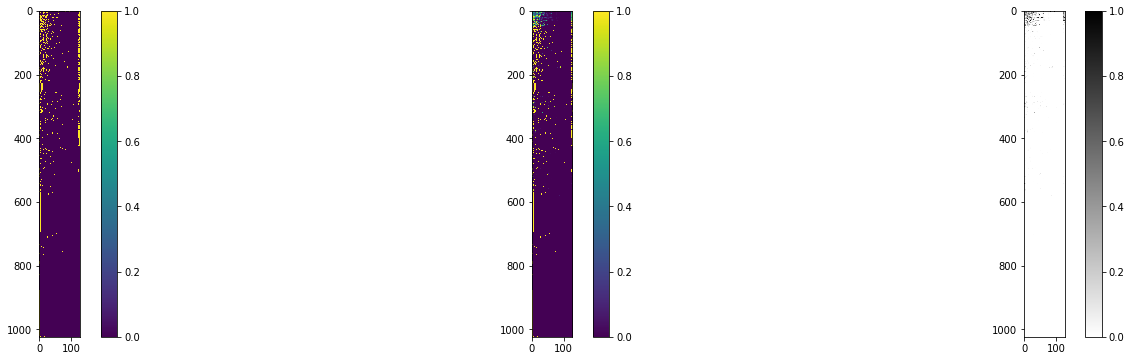

3.471023e-08
0.96702886


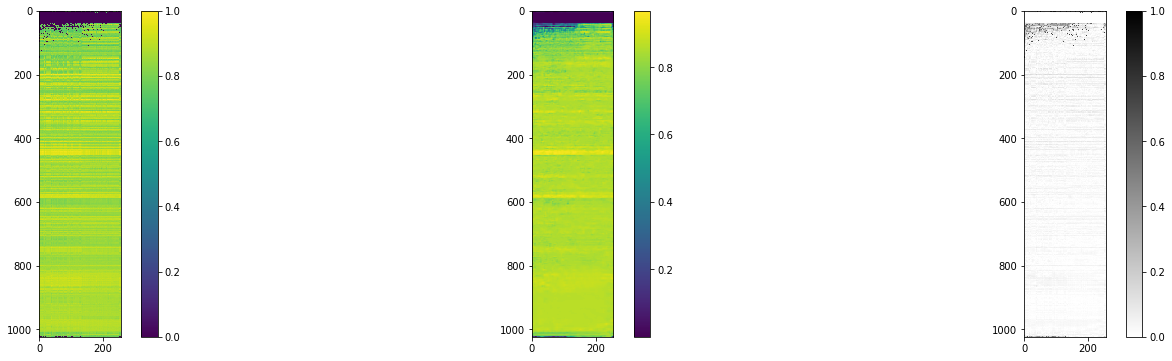

1.5638145e-08
0.43488923


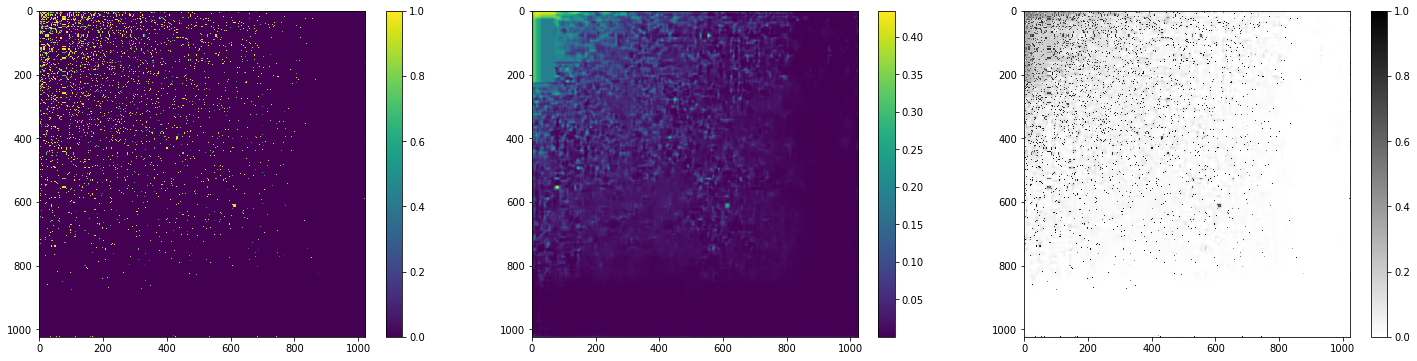

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_05/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


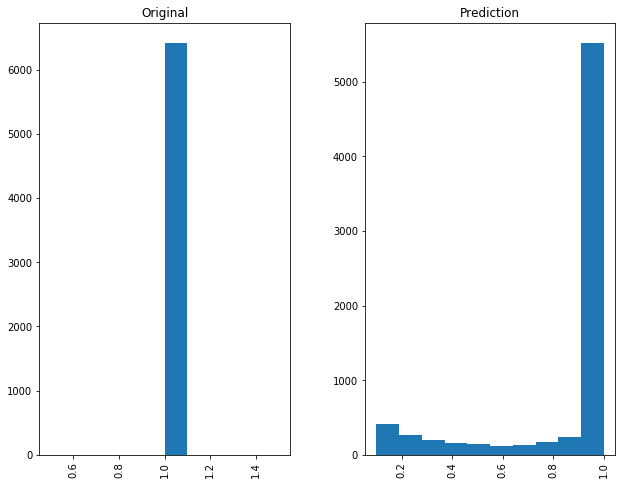

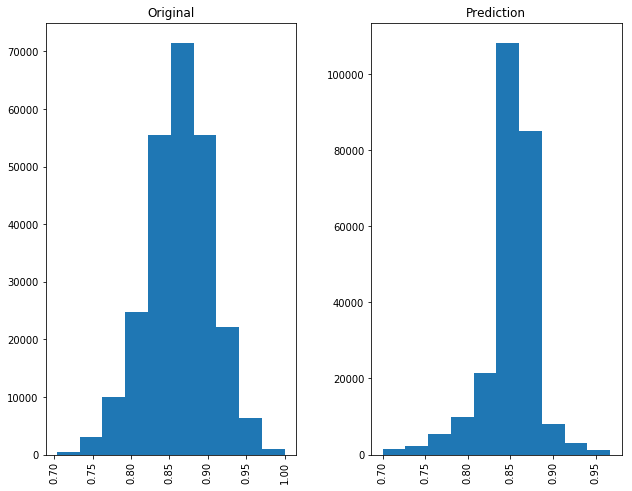

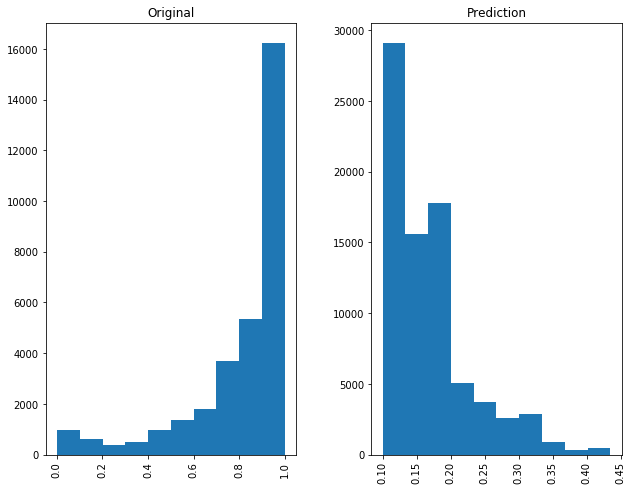

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


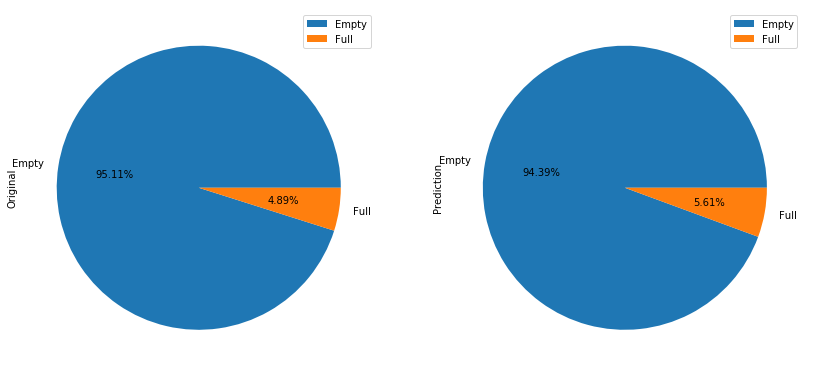

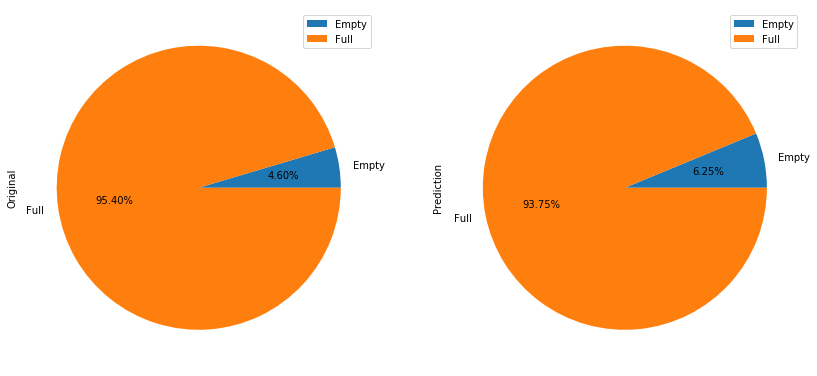

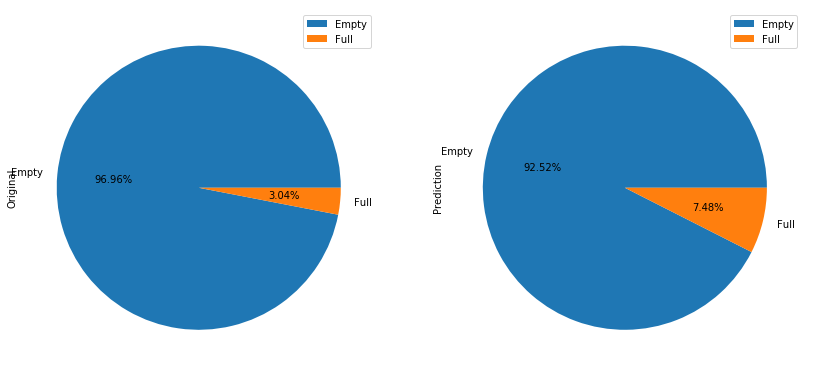

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

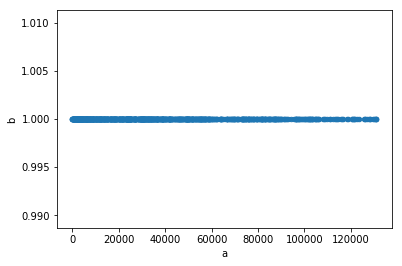

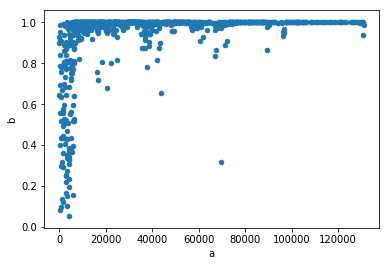

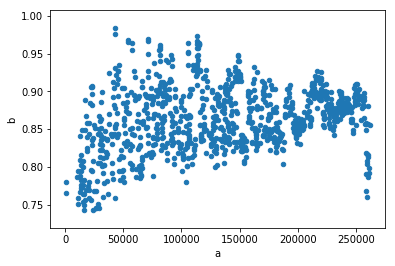

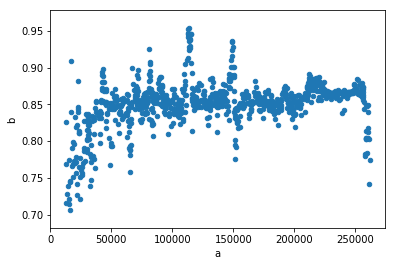

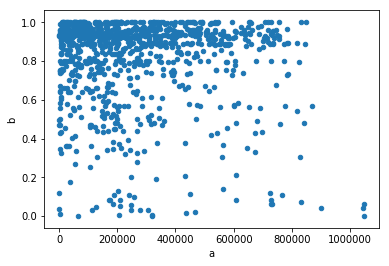

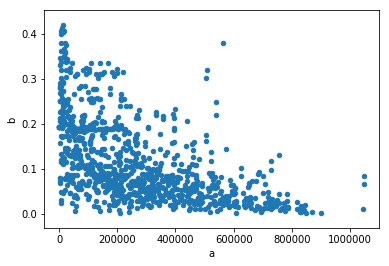

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

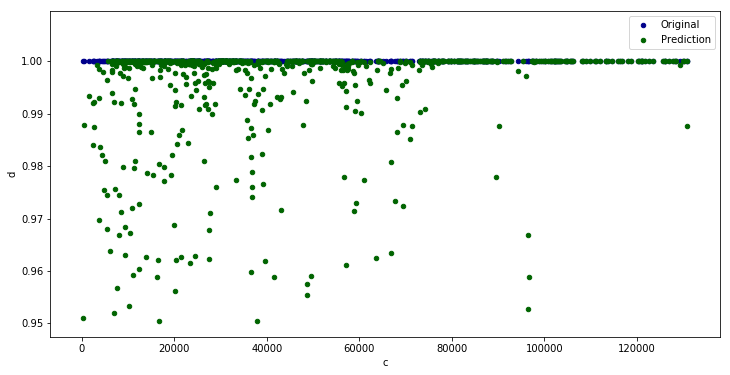

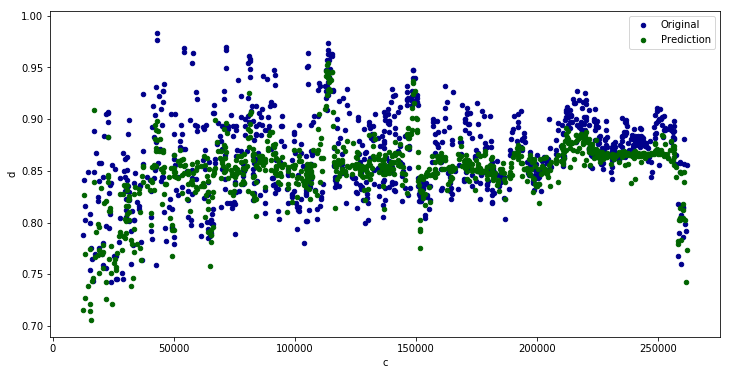

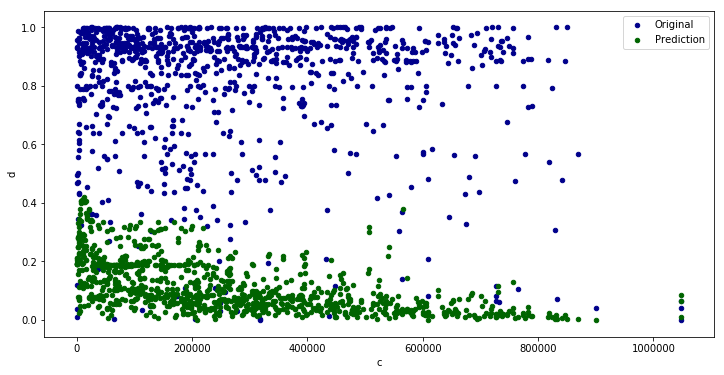

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

            
    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

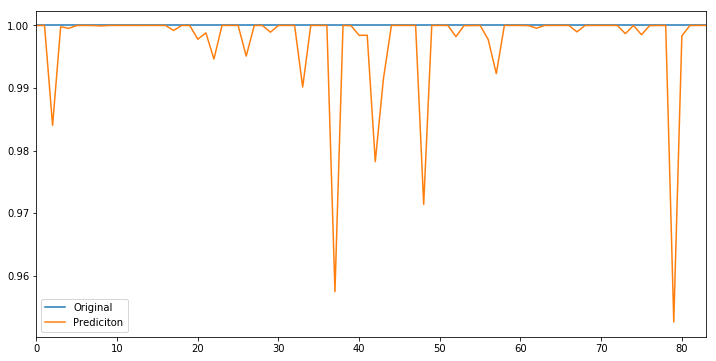

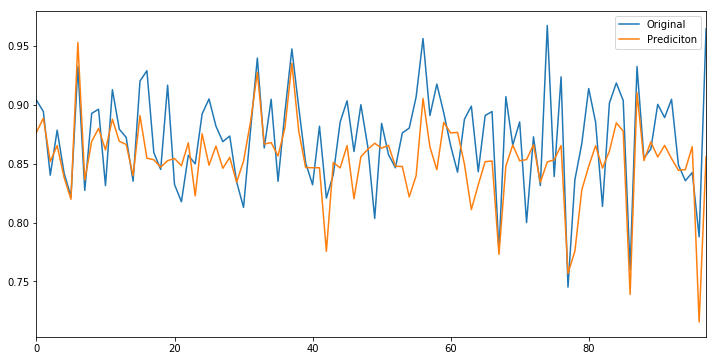

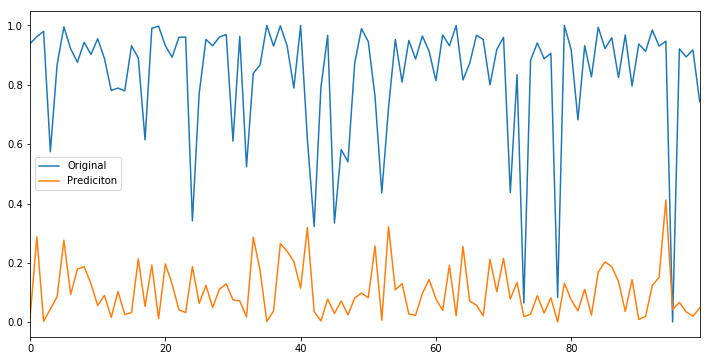

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))